# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenidao.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

# Práctica Final: Clasificación de Texto (NLP) con Scikit-learn y MLflow

En esta práctica, utilizaremos el conjunto de datos de reseñas de productos de bebés Baby_5.json para entrenar un modelo de análisis de sentimiento.Procesaremos texto, entrenaremos un clasificador y gestionararemos su ciclo de vida con MLflow.


Primero, importamos las librerías necesarias y configuramos la conexión con nuestro servidor local de MLflow.

In [ ]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("practica-final-nlp")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1769949951147, experiment_id='2', last_update_time=1769949951147, lifecycle_stage='active', name='practica-final-nlp', tags={'mlflow.experimentKind': 'custom_model_development'}>

Cargamos el dataset de reseñas. Para esta práctica, utilizaremos una muestra de 10,000 reseñas para asegurar que el entrenamiento sea rápido.

In [ ]:
df_raw = pd.read_json('Baby_5.json', lines=True, chunksize=10000)
df = next(df_raw)

df = df[['reviewText', 'overall']].copy()
df = df.dropna(subset=['reviewText'])

df['target'] = (df['overall'] > 3).astype(int)

print(f"Dimensiones del dataset: {df.shape}")
print("Distribución de clases (0=Negativo, 1=Positivo):")
print(df['target'].value_counts(normalize=True))
df.head()

Dimensiones del dataset: (10000, 3)
Distribución de clases (0=Negativo, 1=Positivo):
target
1    0.7613
0    0.2387
Name: proportion, dtype: float64


,reviewText,overall,target
0,Perfect for new parents. We were able to keep ...,5,1
1,This book is such a life saver. It has been s...,5,1
2,Helps me know exactly how my babies day has go...,5,1
3,I bought this a few times for my older son and...,5,1
4,I wanted an alternative to printing out daily ...,4,1


print("Review Positiva:")
print(df[df['target'] == 1]['reviewText'].iloc[0])
print("\nReview Negativa:")
print(df[df['target'] == 0]['reviewText'].iloc[0])

### Experimento balanceado
Generamos un subset equilibrado con 500 reseñas positivas y 500 negativas para comparar cómo cambia el comportamiento del modelo cuando las clases están balanceadas.

In [5]:
positivos = df[df['target'] == 1].sample(500, random_state=42)
negativos = df[df['target'] == 0].sample(500, random_state=42)
df_balanced = pd.concat([positivos, negativos]).sample(frac=1, random_state=42).reset_index(drop=True)
print("Distribución en el subconjunto balanceado:")
print(df_balanced['target'].value_counts())
df_balanced.head()

Distribución en el subconjunto balanceado:
target
0    500
1    500
Name: count, dtype: int64


,reviewText,overall,target
0,The nipple is so long that my infant was gaggi...,1,0
1,I got this to help protect my toddler in our n...,3,0
2,I spent around $50 on a set of these bottles o...,2,0
3,"As soon as I opened the box, I could tell by t...",1,0
4,These sleep sacks are wonderful! My granddaugh...,5,1



Convertir el texto en vectores numéricos. Utilizaremos `TfidfVectorizer` dentro de un `Pipeline` para automatizar este proceso.

In [6]:
X = df['reviewText']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Muestras de entrenamiento: {len(X_train)}")
print(f"Muestras de test: {len(X_test)}")

Muestras de entrenamiento: 8000
Muestras de test: 2000


Configuramos el modelo (Random Forest) y el vectorizador de texto. Registraremos los hiperparámetros y las métricas en MLflow.

In [7]:
X = df['reviewText']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Muestras de entrenamiento: {len(X_train)}")
print(f"Muestras de test: {len(X_test)}")

Muestras de entrenamiento: 8000
Muestras de test: 2000


In [ ]:
n_estimators =150
max_features = 2000

with mlflow.start_run(run_name="NLP_Sentiment_Notebook") as run:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, stop_words='english')),
        ('rf', RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight='balanced'))
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_features", max_features)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    
    mlflow.sklearn.log_model(pipeline, "model", registered_model_name="baby-sentiment-model")
    
    print(f"Modelo entrenado. Accuracy: {acc:.4f}")
    print(f"Run ID: {run.info.run_id}")

2026/02/01 20:18:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'baby-sentiment-model' already exists. Creating a new version of this model...
2026/02/01 20:18:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: baby-sentiment-model, version 13


Modelo entrenado. Accuracy: 0.8135
Run ID: 6894d597c88d422b9710ff5da80112cb
🏃 View run NLP_Sentiment_Notebook at: http://127.0.0.1:5000/#/experiments/2/runs/6894d597c88d422b9710ff5da80112cb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


Created version '13' of model 'baby-sentiment-model'.


Entrenamos el mismo pipeline con el subconjunto equilibrado y registramos un run separado para comparar métricas.

2026/02/01 20:18:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modelo balanceado entrenado. Accuracy: 0.7400
Run ID: 5de5be71e3ba48bb8113d69f83976ebc
🏃 View run NLP_Sentiment_Balanced at: http://127.0.0.1:5000/#/experiments/2/runs/5de5be71e3ba48bb8113d69f83976ebc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


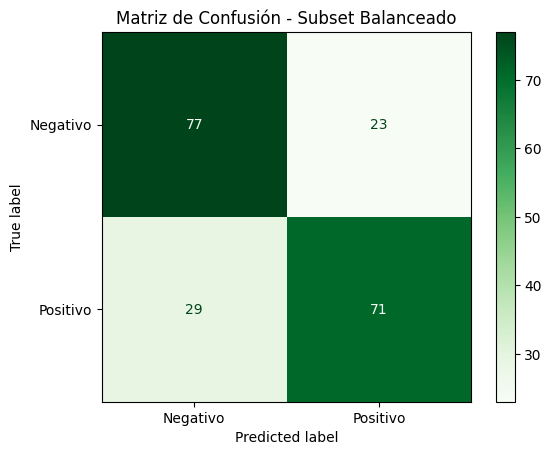

In [9]:
X_bal = df_balanced['reviewText']
y_bal = df_balanced['target']
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

with mlflow.start_run(run_name="NLP_Sentiment_Balanced") as run:
    pipeline_bal = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features, stop_words='english')),
        ('rf', RandomForestClassifier(n_estimators=n_estimators, random_state=42, class_weight='balanced'))
    ])
    pipeline_bal.fit(X_train_bal, y_train_bal)
    y_pred_bal = pipeline_bal.predict(X_test_bal)

    acc_bal = accuracy_score(y_test_bal, y_pred_bal)
    prec_bal = precision_score(y_test_bal, y_pred_bal)
    rec_bal = recall_score(y_test_bal, y_pred_bal)

    mlflow.log_param("balanced_subset", True)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_features", max_features)
    mlflow.log_metric("accuracy_balanced", acc_bal)
    mlflow.log_metric("precision_balanced", prec_bal)
    mlflow.log_metric("recall_balanced", rec_bal)
    mlflow.sklearn.log_model(pipeline_bal, "model_balanced")

    print(f"Modelo balanceado entrenado. Accuracy: {acc_bal:.4f}")
    print(f"Run ID: {run.info.run_id}")

cm_bal = confusion_matrix(y_test_bal, y_pred_bal)
disp_bal = ConfusionMatrixDisplay(confusion_matrix=cm_bal, display_labels=['Negativo', 'Positivo'])
disp_bal.plot(cmap=plt.cm.Greens)
plt.title("Matriz de Confusión - Subset Balanceado")
plt.show()

Al entrenar con clases balanceadas observamos cómo cambian `accuracy`, `precision` y `recall` (ver los runs en MLflow). El run original sobre todo el dataset tiende a predecir "Positivo" porque el 76% de las muestras lo son; el experimento balanceado penaliza más los errores sobre los negativos y genera una matriz de confusión diferente, lo que demuestra que el sesgo viene del desequilibrio de clases.


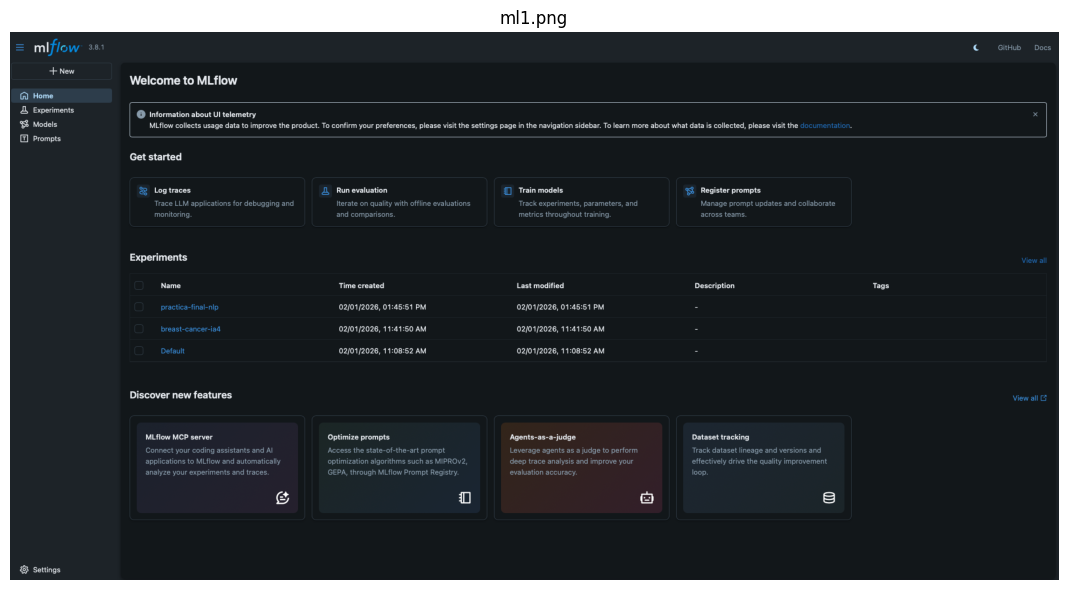

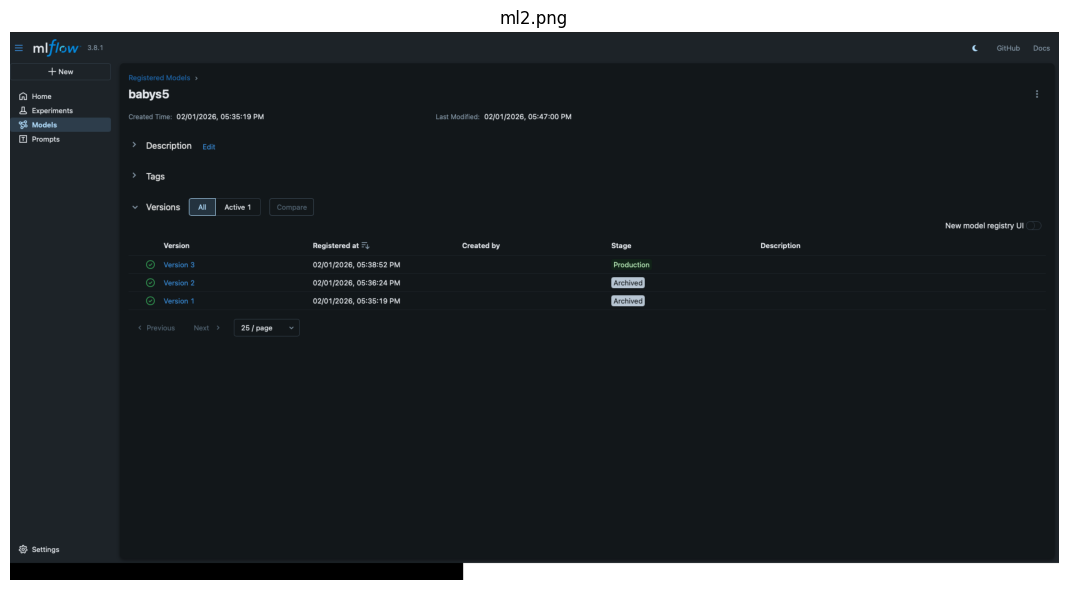

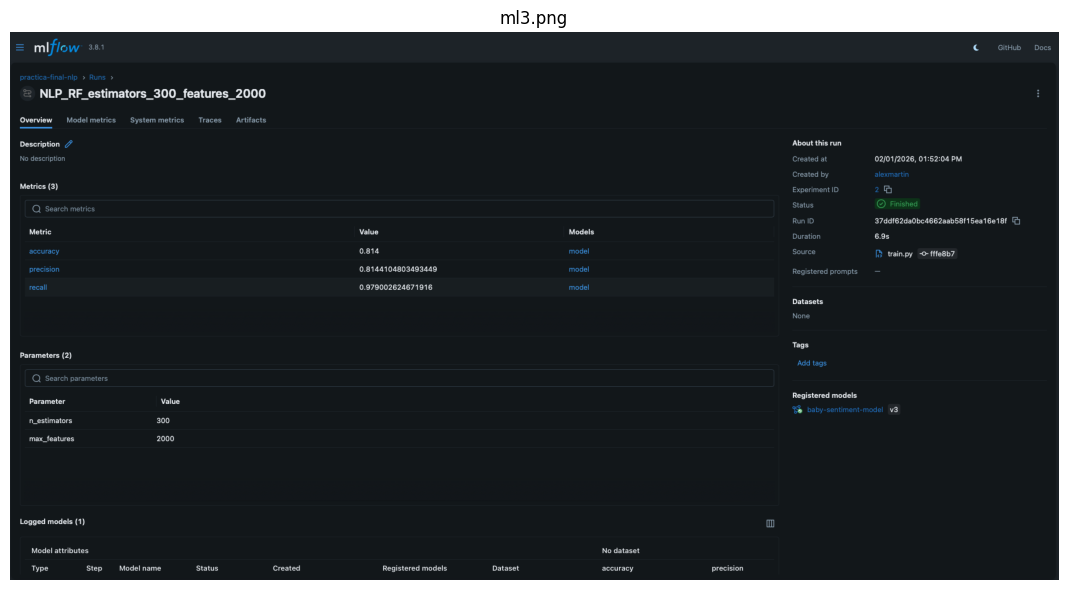

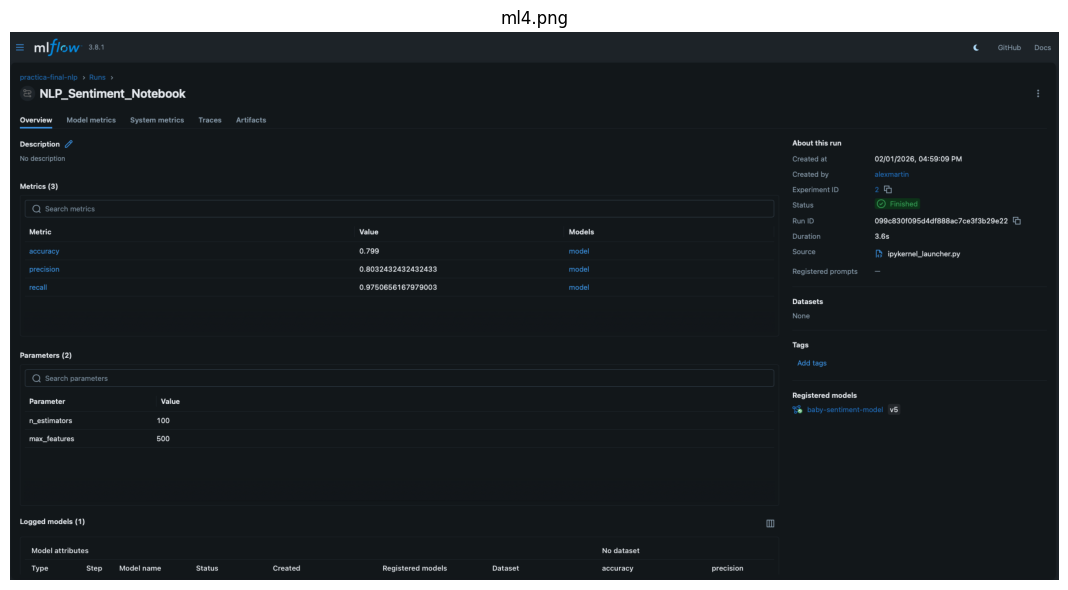

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imagenes = ["ml1.png", "ml2.png", "ml3.png", "ml4.png"]

for nombre_img in imagenes:
    try:
        img = Image.open(nombre_img)
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(nombre_img, fontsize=12)
        plt.tight_layout()
        plt.show()
    except FileNotFoundError:
        print(f"No se encontró el archivo: {nombre_img}")

## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run

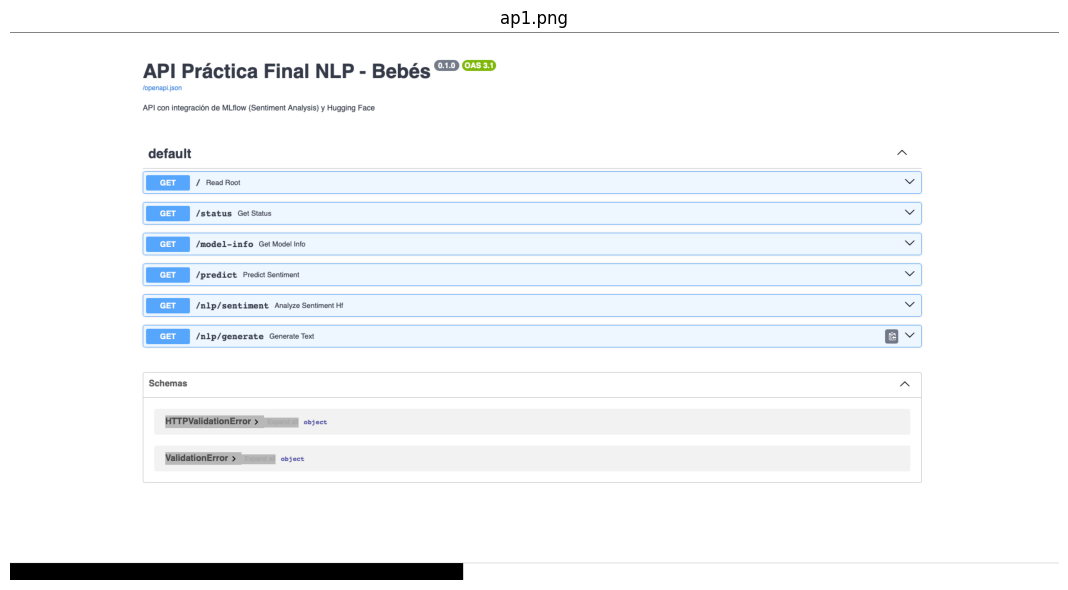

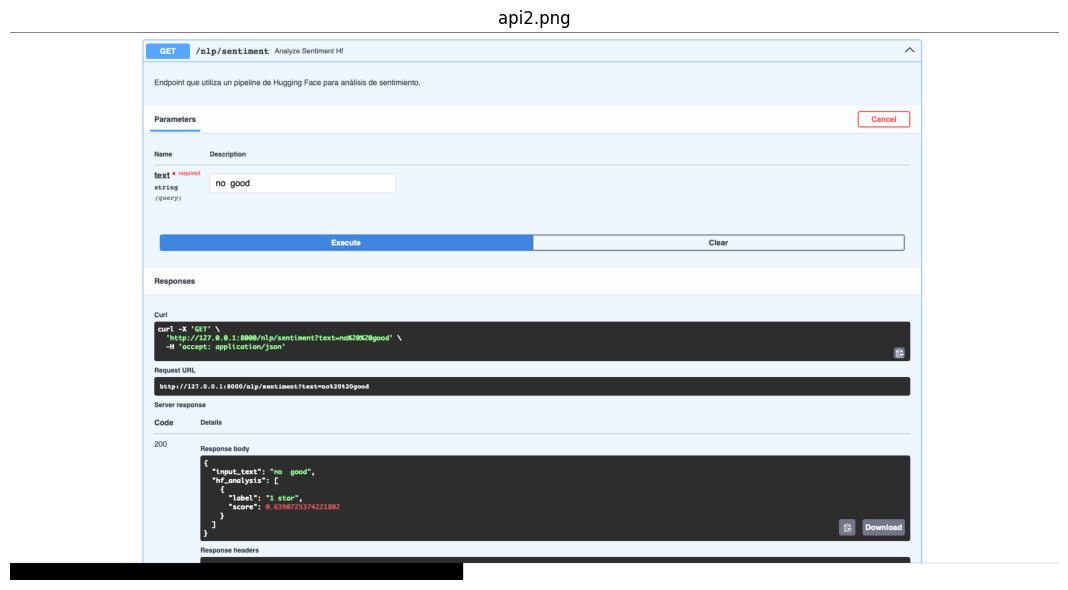

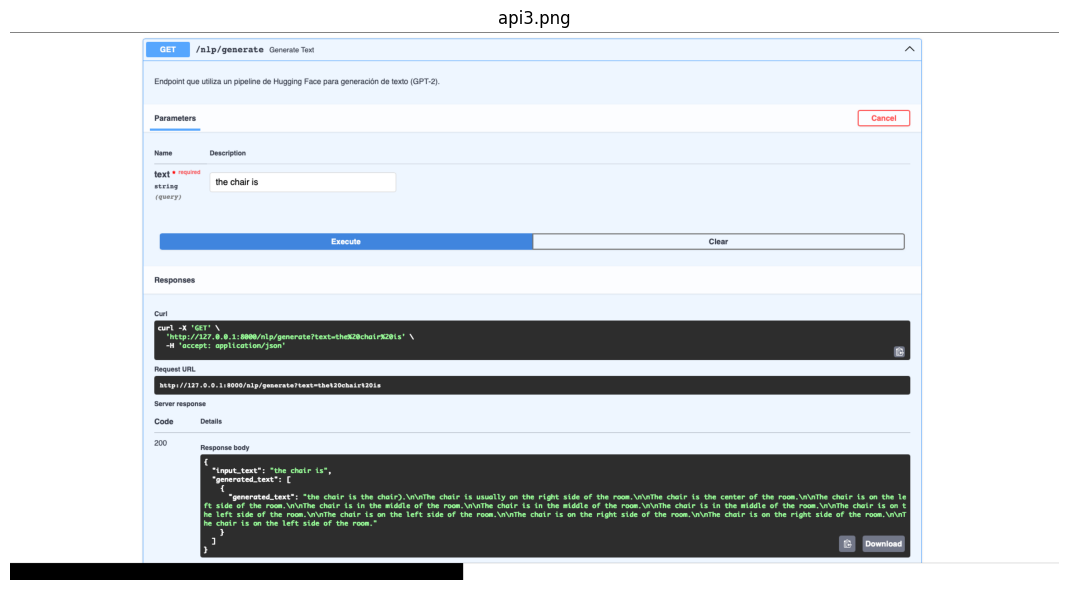

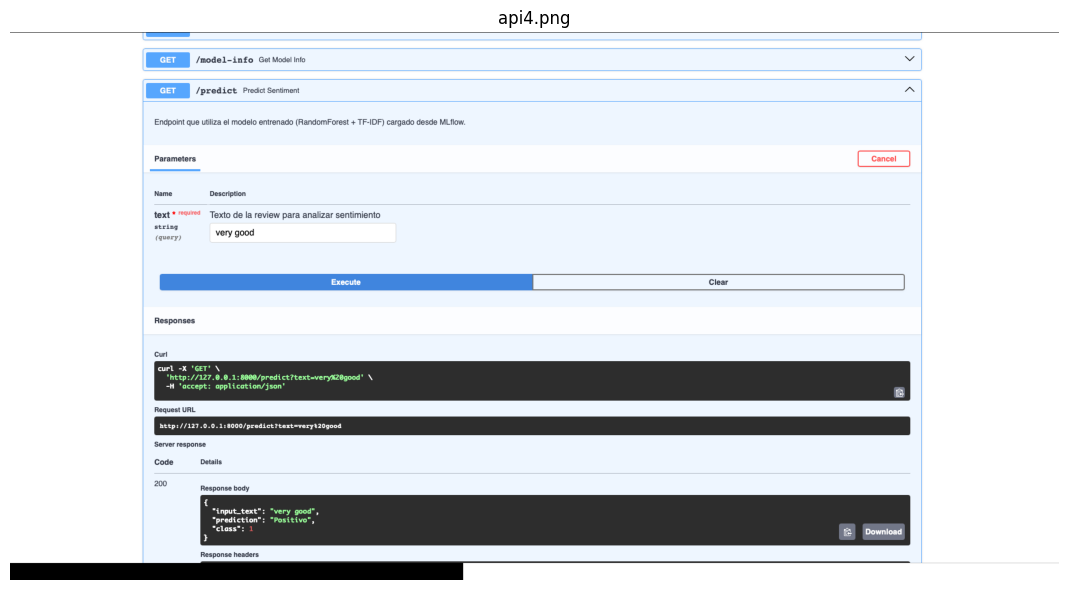

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imagenes = ["ap1.png", "api2.png", "api3.png", "api4.png"]

for nombre_img in imagenes:
    try:
        img = Image.open(nombre_img)
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(nombre_img, fontsize=12)
        plt.tight_layout()
        plt.show()
    except FileNotFoundError:
        print(f"No se encontró el archivo: {nombre_img}")